<a href="https://colab.research.google.com/github/gregorio-saporito/hate-speech-detection/blob/main/main2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining and Sentiment Analysis: Hate Speech Detection
Gregorio Luigi Saporito - DSE (2020-2021)

### Libraries

In [43]:
!pip install text-preprocessing
!pip install tweet-preprocessor
!pip install -U nltk[twitter]

Requirement already up-to-date: nltk[twitter] in /usr/local/lib/python3.7/dist-packages (3.6.2)


In [44]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import preprocessor as p
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, expand_contraction, remove_number, remove_punctuation, remove_whitespace, normalize_unicode, lemmatize_word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
from tqdm import tqdm
from sklearn import utils
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import statistics as st
from sklearn.model_selection import StratifiedKFold

In [45]:
nltk.download('vader_lexicon') 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Upload the data to session storage
Upload here below the __labeled_data.csv__ file. The labels correspond to
- 0: hate speech
- 1: offensive language
- 2: neither

In [46]:
# upload here the data
uploaded = files.upload()

In [47]:
# read the csv file, select the columns of interest, and rename them
fields = ['Unnamed: 0', 'class', 'tweet']
raw = pd.read_csv('labeled_data.csv', usecols=fields)\
  .rename(columns={"Unnamed: 0": "id", "class": "label"})

### Inspect the data

In [48]:
# snapshot of the first rows
raw.head()

,id,label,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [49]:
# size of the dataset
raw.shape

(24783, 3)

In [50]:
# inspect the presence of missing values
print(
    'Check for null values\n' +
    str(raw.isnull().sum()) + '\n'
    'Check for na values\n' +
    str(raw.isna().sum())
)

Check for null values
id       0
label    0
tweet    0
dtype: int64
Check for na values
id       0
label    0
tweet    0
dtype: int64


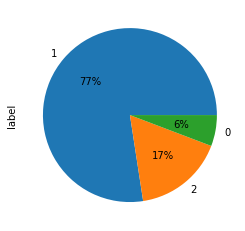

In [51]:
# inspect the classes' frequency
raw['label'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%')
plt.show()

### Preprocessing and Feature Extraction

In [52]:
# normalise tags, URLS, emoji, and smiley
# the hashtags are left out because they could incorporate hate speech to detect
p.set_options(p.OPT.MENTION, p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
raw['normalised'] = [p.tokenize(x) for x in raw['tweet']]

# Preprocess text using custom preprocess functions in the pipeline
def preprocess_txt(x):
  preprocess_functions = [to_lower, expand_contraction, remove_number, remove_punctuation,
                          remove_whitespace, normalize_unicode, lemmatize_word]
  preprocessed_text = preprocess_text(x, preprocess_functions)
  return preprocessed_text.replace("rt ", "").strip()

raw['cleaned'] = [preprocess_txt(x) for x in raw['normalised']]

### TF-IDF Feature Extraction

In [53]:
# split the sample in train and test
corpus_train, corpus_test, y_train, y_test = train_test_split(raw['cleaned'], raw['label'], test_size=0.5, random_state=123)

In [54]:
# fit only on the training set to avoid data leak
# sublinear_tf=True and use_idf=True activated as suggested for TfidfVectorizer later on
vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True)
tfidf = vectorizer.fit(corpus_train)
tfidf_train =  tfidf.transform(corpus_train)
tfidf_test =  tfidf.transform(corpus_test)

# check the shape
print(tfidf_train.shape)
print(tfidf_test.shape)

(12391, 13442)
(12392, 13442)


### Doc2vec Feature extraction

In [55]:
# function to merge the tokenised corpus and labels of the respective train and test sets into a single DataFrame
def token_label(corpus,labels):
  result = pd.DataFrame()
  result['tokens'] = [nltk.word_tokenize(x) for x in corpus]
  result['label'] = labels.tolist()
  return result

# tag documents
train_tagged = token_label(corpus_train,y_train).apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[r.label]), axis=1)
test_tagged = token_label(corpus_test,y_test).apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[r.label]), axis=1)

cores = multiprocessing.cpu_count()

# Doc2Vec model
model_dbow = Doc2Vec(vector_size=300, workers=cores, seed=123)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 12391/12391 [00:00<00:00, 1400097.54it/s]


In [56]:
%%time
for epoch in range(20):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 12391/12391 [00:00<00:00, 1873323.75it/s]


CPU times: user 34.8 s, sys: 4.09 s, total: 38.9 s
Wall time: 28.2 s


In [57]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

# return the features
y_train, doc2vec_train = vec_for_learning(model_dbow, train_tagged)
y_test, doc2vec_test = vec_for_learning(model_dbow, test_tagged)

### Sentiment Feature Extraction

In [58]:
# the order of the output columns is neg, neu, pos
def buildsentdf(corpus):
  sentdf = pd.DataFrame({'neg': [], 'neu': [], 'pos': []})
  sia = SentimentIntensityAnalyzer()
  for x in corpus:
    sentout = sia.polarity_scores(x)
    toappend = pd.DataFrame({'neg': [sentout['neg']], 'neu': [sentout['neu']], 'pos': [sentout['pos']]})
    sentdf = sentdf.append(toappend)
  return sentdf.values

In [59]:
sent_train = buildsentdf(corpus_train)
sent_test = buildsentdf(corpus_test)

### Merge Features

In [60]:
# the features will have to be converted to a common format
print(type(tfidf_train))
print(type(doc2vec_train))
print(type(sent_train))

# check the match of observations
print(tfidf_train.toarray().shape)
print(np.asarray(doc2vec_train).shape)
print(sent_train.shape)

# merge the features
merged_train = np.concatenate((tfidf_train.toarray(),np.asarray(doc2vec_train),sent_train),axis=1)
merged_test = np.concatenate((tfidf_test.toarray(),np.asarray(doc2vec_test),sent_test),axis=1)

# rescale the data (fit only on training to avoid data leak)
scaler = StandardScaler()
scaler_model = scaler.fit(merged_train)
X_train = scaler_model.transform(merged_train)
X_test = scaler_model.transform(merged_test)

# delete intermediate feature preprocessing to save space
del tfidf_train, tfidf_test
del doc2vec_train, doc2vec_test
del sent_train, sent_test
del merged_train, merged_test
del train_tagged, test_tagged

<class 'scipy.sparse.csr.csr_matrix'>
<class 'tuple'>
<class 'numpy.ndarray'>
(12391, 13442)
(12391, 300)
(12391, 3)


### Logistic classifier with dimensionality reduction (LSA)

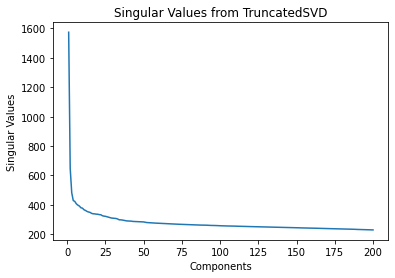

In [61]:
svd = TruncatedSVD(n_components=200, random_state=123)
svd_model = svd.fit(X_train)

# plot singular values to have an idea of how many components to select
fig = plt.figure()
ax = plt.axes()

ax.plot(range(1,201), svd_model.singular_values_)
plt.title('Singular Values from TruncatedSVD')
plt.xlabel('Components')
plt.ylabel('Singular Values')

plt.show()

In [62]:
# tune the model and transform training and test sets accordingly
svdtuned = TruncatedSVD(n_components=50, random_state=123)
svdtuned_model = svdtuned.fit(X_train)
reduced_X_train = svdtuned_model.transform(X_train)
reduced_X_test = svdtuned_model.transform(X_test)

In [63]:
logistic = LogisticRegression(max_iter=10000,random_state=123,penalty='none')
logistic_model = logistic.fit(reduced_X_train, y_train)
print("5-fold cross validation score")
cv = StratifiedKFold(n_splits=5)
st.mean(cross_val_score(logistic_model, reduced_X_test, y_test, cv=cv))

5-fold cross validation score


0.8202872490502139

### Logistic enriched with regularisation

In [64]:
logisticl2 = LogisticRegression(max_iter=10000,random_state=123,penalty='l2')
logisticl2_model = logisticl2.fit(reduced_X_train, y_train)
print("5-fold cross validation score")
cv = StratifiedKFold(n_splits=5)
st.mean(cross_val_score(logisticl2_model, reduced_X_test, y_test, cv=cv))

5-fold cross validation score


0.8207715105514245